# Lab #1 - Object Detection & Tracking (use case: Basketball)

--------

## Lab #1.1 - Object Detection

In this lab, we will run an object detection example on frames extracted from videos. For this purpose we will:
- Create a video object detection labeling job with Amazon SageMaker GroundTruth
- Train an object detection model on the labeled data with an Amazon SageMaker estimator, applying transfer learning with a pre-trained model from a model zoo
- Deploy the trained model to an Amazon SageMaker endpoint for performing some real-time inferences with sample frames

<img src="../images/Lab1_1.jpeg" alt="Lab1_1" width="800"/>

## Setup

Uncomment and run this cell only the first time.

In [2]:
!pip install opencv-python

     |████████████████████████████████| 50.4 MB 54 kB/s s eta 0:00:01


#### Libraries

In [3]:
import sagemaker
from sagemaker.mxnet import MXNet
import mxnet as mx
import gluoncv as gcv
from gluoncv import model_zoo, data, utils
import matplotlib.pyplot as plt
import glob, math, logging
import numpy as np
import json, cv2, os
import boto3
import ast, uuid, time

#### Variables

In [15]:
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = 'rodzanto2020ml'
#bucket = sagemaker_session.default_bucket()
task = 'basketball-60-od-2'
images_prefix = 'sports/basketball/basketball.mp4'
label_prefix = 'sports/basketball/frames/{}'.format(task)
classes = ['ball', 'referee']
inf_prefix = 'sports/basketball/validation_sample'

print('Execution_role:',role)
print('S3_bucket:',bucket)
print('Ground-truth_labeling task:',task)
print('S3_images_prefix:',images_prefix)
print('S3_label_prefix:',label_prefix)
print('Labeling_classes:',classes)
print('S3_inference_prefix:',inf_prefix)

Execution_role: arn:aws:iam::889960878219:role/service-role/AmazonSageMaker-ExecutionRole-20180920T165537
S3_bucket: rodzanto2020ml
Ground-truth_labeling task: basketball-60-od-2
S3_images_prefix: sports/basketball/basketball.mp4
S3_label_prefix: sports/basketball/frames/basketball-60-od-2
Labeling_classes: ['ball', 'referee']
S3_inference_prefix: sports/basketball/validation_sample


## Labeling

Create an object detection labeling job using SageMaker Ground Truth for a sample video. For simplicity, we will configure it such that it will extract an image every 60 frames, and only consider 4 classes: the ball, the area of midfield, the goal area, and one of the players.

#### Create a Labeling Workforce

Follow the steps in the SageMaker Ground Truth documentation here: https://docs.aws.amazon.com/sagemaker/latest/dg/sms-workforce-create-private-console.html#create-workforce-labeling-job

#### Create your bounding box labeling job

Follow the steps in the SageMaker Ground Truth documentation here: https://docs.aws.amazon.com/sagemaker/latest/dg/sms-create-labeling-job-console.html

If using the AWS Console, you should create a labeling job with the following options:
1. Job name: Set any name, e.g. in our example we use "football2-60-od-images".
2. Leave the "I want to specify a label attribute..." option un-checked.
3. Input data setup: Pick "Automated data setup".
4. Input dataset location: Copy and paste the location of the folder/prefix with your video in S3, e.g. in our example we use "s3://rodzanto2020ml/sports/football2_in/"
5. Output dataset location: Choose "Same location as input dataset", or copy and paste the location of the folder/prefix for storing the result of the annotations in your labeling job, e.g. in our example we use: "s3://rodzanto2020ml/sports/football2_in/football2-60-od-images/football2-60-od-images/".
6. Data type: Choose "Video Files".
7. Frame extraction: Choose to use every "60" frames from the video.
8. IAM Role: Chose the existing role in your account. Now hit "Complete data setup" and wait for it to be ready. `Note this step takes a few minutes to complete`
9. Task category: Choose "Video" and select "Video object detection"->"Bounding box" *(do not confuse with "Video object tracking"->"Bounding box")*, then hit "Next"
10. Worker types: Select "Private" and choose your team for the "Private teams" option.
11. Video object detection: Enter a description and instructions, and for the "Labels" section add the relevant labels for your job, e.g. in our example we use "ball", "midfield", "goal", "cristiano". Finally choose "Create".

If you prefer to create the labeling job programatically via APIs with the SageMaker SDK, follow the instructions here: https://docs.aws.amazon.com/sagemaker/latest/dg/sms-bounding-box.html, adapting the example code to the parameters above.

After a few minutes, you should be able to access your Labeling portal sign-in URL (check the URL in the "Private workforce summary" page) and see the labeling job ready for working on it.

#### Inspect labels

The "manifest file" is created after completing the labeling job using SageMaker Ground Truth. It contains metadata about the images and the associated labels.

In [16]:
# Download output.manifest from the S3 bucket to the local notebook, if it doesn't exist locally already
s3 = boto3.resource('s3')
if not os.path.isfile('output.manifest.{}'.format(task)):
    s3.Bucket(bucket).download_file('{}/annotations/consolidated-annotation/output/0/SeqLabel.json'.format(label_prefix), 'output.manifest.{}'.format(task))    

On each image, there are one or more objects labeled. We can read this information from the `output.manifest` file.

In [70]:
image_info = []
with open('output.manifest.{}'.format(task)) as f_in: 
    file_data = f_in.read() 
    file_data = file_data.replace("}{", "},{") 
    file_data = "[" + file_data + "]"
    image_info = json.loads(file_data)        

info = image_info[0]['detection-annotations']

#for frame in info:
#    if len(frame['annotations']):
#        print(frame)

info = info[0]
print("Total number of images: {}".format(len(image_info)))
print("Ground Truth labeling for the first sample image:")
info

Total number of images: 1
Ground Truth labeling for the first sample image:


{'annotations': [{'height': 27,
   'width': 23,
   'top': 233,
   'left': 918,
   'class-id': '0',
   'label-category-attributes': {}},
  {'height': 123,
   'width': 46,
   'top': 262,
   'left': 894,
   'class-id': '1',
   'label-category-attributes': {}}],
 'frame-no': '1',
 'frame': 'frame_0001.jpeg',
 'frame-attributes': {}}

Let's plot some of the labels, remember this is the result of the annotation done using SageMaker Ground Truth:

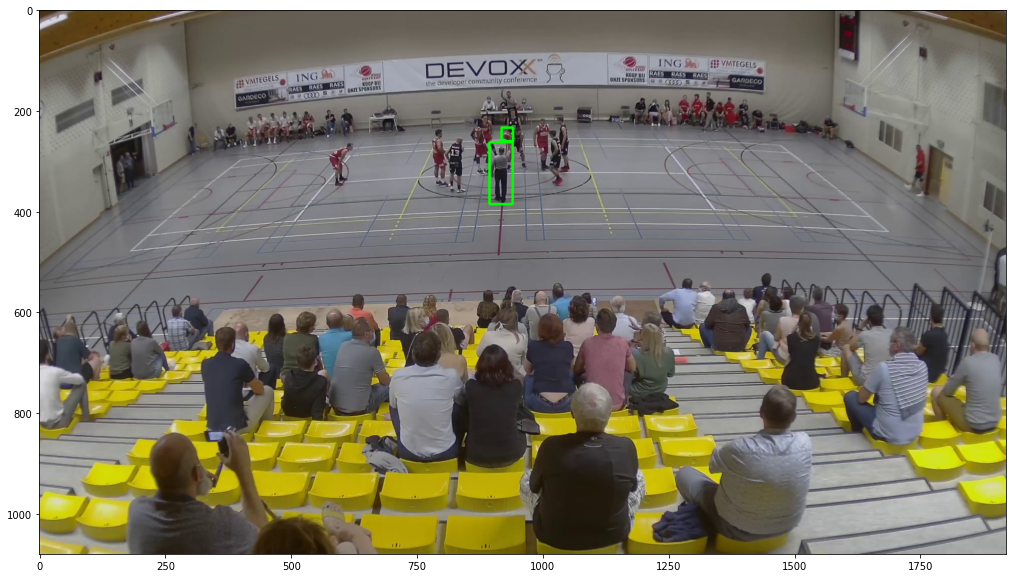

In [77]:
def substring_after(s, delim):
    return s.partition(delim)[2]

class_map = classes
#image = plt.imread(os.path.join("sample_images",info['source-ref'].split('/')[-1]))
s3.Bucket(bucket).download_file('{}/{}'.format(images_prefix, info['frame']), \
    '../sample_media/basketball_{}'.format(info['frame']))

image = plt.imread('../sample_media/basketball_{}'.format(info['frame']))
boxes = info['annotations']

plt.figure(figsize = (20,10))
for box in boxes:
    cv2.rectangle(image, (int(box['left']), int(box['top'])), (int(box['left']+box['width']), int(box['top']+box['height'])), (0,255,0), 3)
plt.imshow(image)
plt.show()

## Training using transfer learning

We will use the weights from a pre-trained MobileNet SSD neural network to detect our objects. MobileNets are lightweight networks for computer vision applications. The training will remove the last layer from the pre-trained network and replace it with a new output layer that predicts our labels.

The model will be taken from the MXNet GluonCV model-zoo: https://cv.gluon.ai/api/model_zoo.html#mobilenet

We will create an estimator with the Amazon SageMaker Python SDK, pointing to our training script located at: `entry_point/gluoncv_detection_ssd.py`.

In [81]:
!pygmentize entry_point/gluoncv_detect_ssd-basketball.py

import argparse
import os
import json
import time
import random
import numpy as np
import mxnet as mx
from mxnet import autograd, gluon

import subprocess
subprocess.run(["pip",  "install", "gluoncv==0.8.0"])

import gluoncv as gcv
from gluoncv.data.batchify import Tuple, Stack, Pad
from gluoncv.data.transforms.presets.ssd import SSDDefaultTrainTransform
from gluoncv import model_zoo, data, utils

class GroundTruthDetectionDataset(gluon.data.Dataset):
    """
    Custom Dataset to handle the GroundTruthDetectionDataset
    """
    def __init__(self, label_path, data_path, task, split='train'):
        """
        Parameters
        ---------
        data_path: str, Path to the data folder, default 'data'
        split: str, Which dataset split to request, default 'train'
    
        """
        self.data_path = data_path
        self.image_info = []
        self.task = task
        with open(os.path.join(label_path,'SeqLabel.json')) as f: 
            file_data = f.read() 
           

In [85]:
mxnet_estimator = MXNet(entry_point = 'gluoncv_detect_ssd-basketball.py',
                        source_dir = 'entry_point',
                        role = role,
                        instance_type = 'ml.p3.2xlarge',
                        instance_count = 1,
                        image_uri = '763104351884.dkr.ecr.eu-west-1.amazonaws.com/mxnet-training:1.7.0-gpu-py36-cu101-ubuntu16.04',
                        container_log_level = 40,
                        hyperparameters={'gt_labeling_task': task,
                                         'base_network': 'ssd_512_mobilenet1.0_custom',
                                         'classes': classes,
                                         'epochs': 20,
                                         'learning_rate': 0.001,
                                         'wd': 0.0005})

#### Fit model

In [ ]:
s3_train_data = 's3://{}/{}/'.format(bucket, images_prefix)
s3_label_data = 's3://{}/{}/annotations/consolidated-annotation/output/0/'.format(bucket, label_prefix)
job_name = '{}-{}'.format(task,str(uuid.uuid4()))
mxnet_estimator.fit({'train': s3_train_data, 'labels': s3_label_data}, job_name=job_name)
print('SageMaker Training Job:',job_name)

2021-03-05 02:13:51 Starting - Starting the training job...
2021-03-05 02:14:15 Starting - Launching requested ML instancesProfilerReport-1614910430: InProgress
......
2021-03-05 02:15:15 Starting - Preparing the instances for training......
2021-03-05 02:16:16 Downloading - Downloading input data...
2021-03-05 02:16:44 Training - Downloading the training image.....Requirement already satisfied: Pillow in /usr/local/lib/python3.6/site-packages (from -r requirements.txt (line 1)) (8.1.0)
You should consider upgrading via the 'pip install --upgrade pip' command.

2021-03-05 02:17:37 Training - Training image download completed. Training in progress.Collecting gluoncv==0.8.0
  Found existing installation: gluoncv 0.6.0
    Uninstalling gluoncv-0.6.0:
      Successfully uninstalled gluoncv-0.6.0
You should consider upgrading via the 'pip install --upgrade pip' command.
[2021-03-05 02:17:40.485 ip-10-0-122-134.eu-west-1.compute.internal:22 INFO json_config.py:90] Creating hook from json_con

`- Note: With the full dataset this step takes around 2 hours to complete. -`

## Deployment and inference

#### Real-time inference

Here we deploy our model as a SageMaker endpoint for generating predictions on new sample images.

In [88]:
model_name = task+'-{0}'.format(str(int(time.time())))
model_data = 's3://{}/{}/output/model.tar.gz'.format(sagemaker_session.default_bucket(), job_name)
print(model_data)
from sagemaker.mxnet.model import MXNetModel
sagemaker_model = MXNetModel(model_data = model_data,
                             entry_point = 'gluoncv_detect_ssd-basketball.py',
                             source_dir = 'entry_point',
                             role = role,
                             image_uri = '763104351884.dkr.ecr.eu-west-1.amazonaws.com/mxnet-inference:1.7.0-gpu-py36-cu101-ubuntu16.04',
                             framework_version='1.7.0',
                             py_version='py3',
                             container_log_level = 40,
                             model_server_workers=10,
                             name=model_name)
print('SageMaker Model:',sagemaker_model.name)

s3://sagemaker-eu-west-1-889960878219/basketball-60-od-2-c2c3de8f-3a18-4165-9d59-f5c0622dc66f/output/model.tar.gz
SageMaker Model: basketball-60-od-2-1614939423


In [90]:
logging.getLogger().setLevel(logging.WARNING)
endpoint_name = task+'-{0}'.format(str(int(time.time())))
predictor = sagemaker_model.deploy(initial_instance_count=1,
                                   instance_type='ml.g4dn.2xlarge',
                                   endpoint_name=endpoint_name)
print('SageMaker Endpoint:',endpoint_name)

Using already existing model: basketball-60-od-2-1614939423


---------------!SageMaker Endpoint: basketball-60-od-2-1614939544


`- Note: This step takes around 6-7 minutes to complete. -`

We have now deployed our GluonCV object detection model in SageMaker, let's retrieve this endpoint.

Finally, let's load some sample images and pass them to the endpoint. Sample images are available in `sample_media/`.

Sample images found: ['../sample_media/basketball_frame_0043.jpeg', '../sample_media/basketball_frame_0182.jpeg', '../sample_media/basketball_t1.jpeg', '../sample_media/basketball_frame_0001.jpeg', '../sample_media/basketball_frame_0089.jpeg']
Running inference on image: ../sample_media/basketball_frame_0043.jpeg
Running inference on image: ../sample_media/basketball_frame_0182.jpeg
Running inference on image: ../sample_media/basketball_t1.jpeg
Running inference on image: ../sample_media/basketball_frame_0001.jpeg
Running inference on image: ../sample_media/basketball_frame_0089.jpeg
Running inference on 5 images.


<Figure size 1440x360 with 0 Axes>

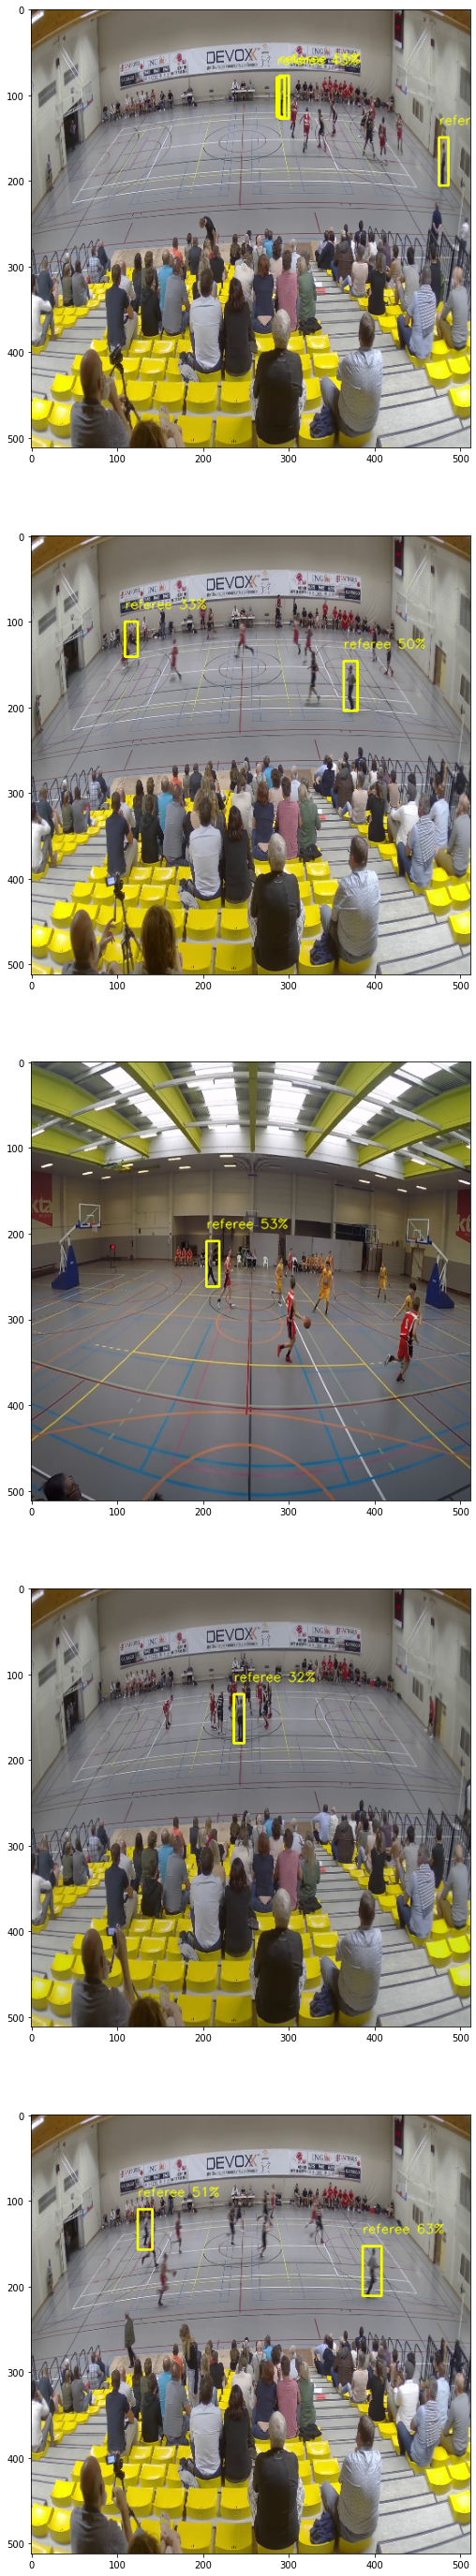

In [100]:
%matplotlib inline

runtime = boto3.client('runtime.sagemaker')
client = boto3.client('sagemaker')

eval_images = glob.glob("../sample_media/basketball*.jpeg")
print('Sample images found:',eval_images)
n_images = len(eval_images)
cols = (int(math.sqrt(n_images)))*2

fig = plt.figure(figsize = (20,5))
imgs = []
for n, (image) in enumerate(eval_images[:n_images]):
    orig_img = cv2.imread(image)
    orig_img = cv2.resize(orig_img, (512,512))
    payload = json.dumps(orig_img.tolist())
    print('Running inference on image:',eval_images[n])
    response = runtime.invoke_endpoint(EndpointName = endpoint_name, Body = payload)
    time.sleep(3)
    response_body = response['Body']
    result = json.loads(response_body.read().decode())
    [class_IDs, scores, bounding_boxes] = result
   
    bounding_boxes, scores, class_IDs =  mx.nd.array(bounding_boxes), mx.nd.array(scores), mx.nd.array(class_IDs)
    ax = utils.viz.cv_plot_bbox(orig_img, bounding_boxes[0], scores[0], class_IDs[0], 
                                thresh=0.3, class_names = ["ball", "referee"], colors = {0: (0, 255, 0)})
    imgs.append(orig_img)   

print('Running inference on',len(imgs),'images.')
fig = plt.figure(figsize = (50, 50))
columns = 1
rows = len(imgs)
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(cv2.cvtColor(imgs[i-1], cv2.COLOR_BGR2RGB))
plt.show()

(Optional) Remember to delete the SageMaker endpoint after you are done with the testing inferences, for avoiding unnecessary costs.

In [138]:
print("Endpoint name: " + endpoint_name)
#predictor.delete_endpoint()

Endpoint name: football2-60-od-images-1612788120


Good job, we have completed the object detection part of the lab.
In the next section we will explore object tracking.

...

--------

## Lab #1.2 Object Tracking

In this lab, we will run an object tracking example on frames extracted from videos. For this purpose we will:
- Create a video object tracking labeling job with Amazon SageMaker GroundTruth
- Load a pre-trained object tracking model from a model zoo
- Performing some real-time inferences with sample frames on the pre-trained model

<img src="../images/Lab1_2.jpeg" alt="Lab1_2" width="800"/>

In [101]:
task = 'basketball-60-od-2'
images_prefix = 'sports/basketball/basketball.mp4'
label_prefix = 'sports/basketball/frames/{}'.format(task)
classes = ['ball', 'referee']
inf_prefix = 'sports/basketball/validation_sample'

print('Execution_role:',role)
print('S3_bucket:',bucket)
print('Ground-truth_labeling task:',task)
print('S3_images_prefix:',images_prefix)
print('S3_label_prefix:',label_prefix)
print('Labeling_classes:',classes)
print('S3_inference_prefix:',inf_prefix)

Execution_role: arn:aws:iam::889960878219:role/service-role/AmazonSageMaker-ExecutionRole-20180920T165537
S3_bucket: rodzanto2020ml
Ground-truth_labeling task: basketball-60-od-2
S3_images_prefix: sports/basketball/basketball.mp4
S3_label_prefix: sports/basketball/frames/basketball-60-od-2
Labeling_classes: ['ball', 'referee']
S3_inference_prefix: sports/basketball/validation_sample


## Labeling

Create an object tracking labeling job using SageMaker Ground Truth for a sample video. For simplicity, we will configure it such that it will extract an image every 60 frames, and only consider 4 classes: the ball, the area of midfield, the goal area, and one of the players.

Repeat the steps of the previous for creating a labeling job, but this time choose "Video object tracking"->"Bounding box". This will allow you labeling different instances of the objects, and therefore "follow" a given instance across the frames of the video.

#### Inspect labels

The "manifest file" was created after completing the labeling job using SageMaker Ground Truth. It contains metadata about the images and the associated labels.

In [16]:
# Download output.manifest from the S3 bucket to the local notebook, if it doesn't exist locally already
s3 = boto3.resource('s3')
if not os.path.isfile('output.manifest.{}'.format(task)):
    s3.Bucket(bucket).download_file('{}/annotations/consolidated-annotation/output/0/SeqLabel.json'.format(label_prefix), 'output.manifest.{}'.format(task))    

On each image, there are one or more objects labeled. We can read this information from the `output.manifest` file.

In [70]:
image_info = []
with open('output.manifest.{}'.format(task)) as f_in: 
    file_data = f_in.read() 
    file_data = file_data.replace("}{", "},{") 
    file_data = "[" + file_data + "]"
    image_info = json.loads(file_data)        

info = image_info[0]['detection-annotations']

#for frame in info:
#    if len(frame['annotations']):
#        print(frame)

info = info[0]
print("Total number of images: {}".format(len(image_info)))
print("Ground Truth labeling for the first sample image:")
info

Total number of images: 1
Ground Truth labeling for the first sample image:


{'annotations': [{'height': 27,
   'width': 23,
   'top': 233,
   'left': 918,
   'class-id': '0',
   'label-category-attributes': {}},
  {'height': 123,
   'width': 46,
   'top': 262,
   'left': 894,
   'class-id': '1',
   'label-category-attributes': {}}],
 'frame-no': '1',
 'frame': 'frame_0001.jpeg',
 'frame-attributes': {}}

## Training using pre-trained models

For multiple objects tracking, we can use the weights from a pre-trained Single-Shot Multi Object Tracking (SMOT) neural network. SMOT is a new tracking framework that converts any single-shot detector (SSD) model into an online multiple object tracker, which emphasizes simultaneously detecting and tracking of the object paths.

If your use case is for tracking a single object, you could also consider using a Siamese Region Proposal Network (SiamRPN). SiamRPN is a widely adopted single object tracking method that consists of a Siamese subnetwork for feature extraction, and a region proposal subnetwork including the classification branch and regression branch for prediction. In the inference phase, the proposed framework is formulated as a local one-shot detection task. We can pre-compute the template branch of the Siamese subnetwork and formulate the correlation layers as trivial convolution layers to perform online tracking.

For more information on these tracking networks you can check: https://cv.gluon.ai/build/examples_tracking/index.html

### Example with pre-trained SiamRPN model

GluonCV's SiamRPN model is very stable for know objects. It can track the object even when it moves at high speed and is partially occluded.
Try it on your own video and see the results!

We need two things to start the tracking demo, the video and its first frame object coordinates. The coordinates show the region of interest where to track, and in the format of (min_x, min_y, width, height).

Here we specify a sample video and set the region of interest in the first frame, in this example: the location of the ball in the field.

<img src="../images/Lab1_2_1.jpeg" alt="Lab1_2_1" width="800"/>

In [119]:
video_path = '../sample_media/basketball_cut.mp4'
#Bounding box of the object to detect according to the first frame of your own video:
gt_min_x = 782
gt_min_y = 756
gt_w = 22
gt_h = 22

if not os.path.exists('predictions'):
    os.makedirs('predictions')

Then you can simply use the GluonCV provided script to obtain the object tracking result.

In [120]:
!python gluoncv/demo.py --video-path $video_path --gt-bbox $gt_min_x $gt_min_y $gt_w $gt_h --save-dir './basketball_predictions'

../sample_media/basketball_cut.mp4
Figure(640x480)


In [121]:
import os

files = [f for f in os.listdir('./predictions') if f[-3:] == 'jpg']
files.sort()

def make_video(images, outvid, outimg=None, fps=25, size=None,
               is_color=True, format="XVID"):
    from cv2 import VideoWriter, VideoWriter_fourcc, imread, resize
    fourcc = VideoWriter_fourcc(*format)
    vid = None
    for image in images:
        image = 'basketball_predictions/{}'.format(image)
        if not os.path.exists(image):
            raise FileNotFoundError(image)
        img = imread(image)
        if vid is None:
            if size is None:
                size = img.shape[1], img.shape[0]
            vid = VideoWriter(outvid, fourcc, float(fps), size, is_color)
        if size[0] != img.shape[1] and size[1] != img.shape[0]:
            img = resize(img, size)
        vid.write(img)
    vid.release()
    return vid

make_video(files, 'SiamRPN_basketball_animation.mp4')

<VideoWriter 0x7fd6165d39f0>

In [49]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('./SiamRPN_basketball_animation.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

`- Note: If the video is not playing in the notebook, you can download it from the "File Browser" in the left panel and play it locally in your PC. -`

Here is a sample image from the resulting tracking animation. Look at the yellow bounding box following the ball.

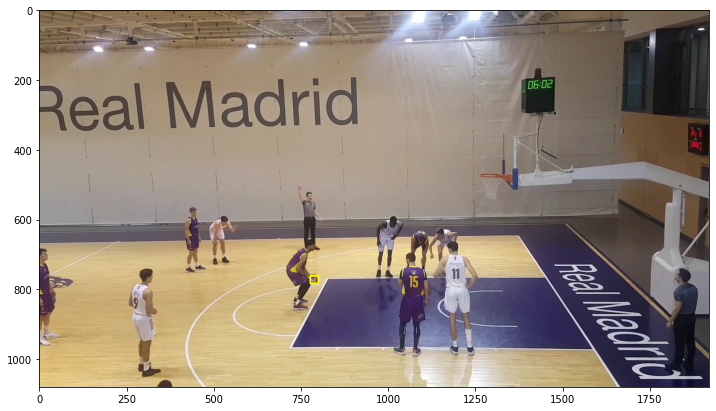

In [124]:
image = plt.imread('basketball_predictions/{}'.format(files[5]))
fig = plt.figure(figsize = (12,10))
plt.imshow(image)
plt.show()

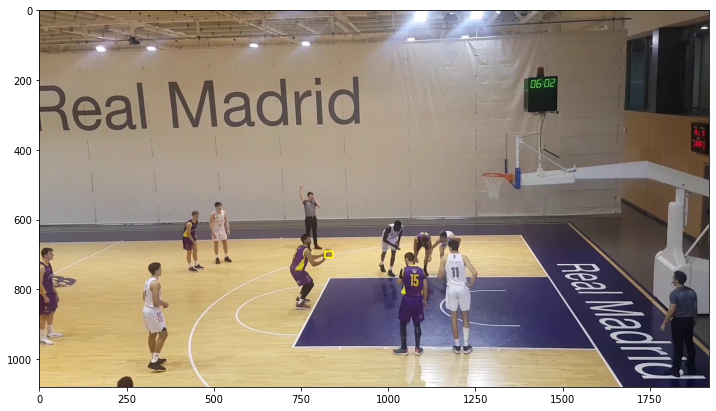

In [125]:
image = plt.imread('basketball_predictions/{}'.format(files[30]))
fig = plt.figure(figsize = (12,10))
plt.imshow(image)
plt.show()

*Note: You could also adapt this example for performing transfer-learning with your own dataset for increasing the accuracy of the tracking, based on this example: https://cv.gluon.ai/build/examples_tracking/index.html*